In [1]:
import datetime as dt
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
tw_weighted = pd.read_csv('TSEC_weighted_index.csv',index_col='Date', parse_dates=True) # 2015/04/30 ~ 2019/04/29

In [7]:
tw_weighted.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-04-30,9841.150391,9894.900391,9820.049805,9820.049805,9820.012695,2644700.0
2015-05-04,9853.509766,9871.650391,9800.480469,9845.040039,9845.002930,2298800.0
2015-05-05,9849.129883,9855.639648,9788.129883,9820.129883,9820.092773,2134800.0
2015-05-06,9780.389648,9829.429688,9735.940430,9818.200195,9818.163086,2353700.0
2015-05-07,9789.820313,9789.820313,9704.110352,9704.110352,9704.073242,2315900.0


In [8]:
tw_weighted_adjclose_volume = tw_weighted[['Adj Close','Volume']] # slice出調整後收盤價跟交易量

In [9]:
tw_weighted_adjclose_volume.head()

,Adj Close,Volume
Date,,
2015-04-30,9820.012695,2644700.0
2015-05-04,9845.002930,2298800.0
2015-05-05,9820.092773,2134800.0
2015-05-06,9818.163086,2353700.0
2015-05-07,9704.073242,2315900.0


In [10]:
vix = pd.read_csv('^VIX.csv', index_col='Date', parse_dates=True) # 2015/04/29 - 2019/04/29

In [12]:
vix_adjclose_volume = vix[['Adj Close','Volume']]

In [13]:
vix_adjclose_volume.head()

,Adj Close,Volume
Date,,
2015-04-29,13.39,0
2015-04-30,14.55,0
2015-05-01,12.70,0
2015-05-04,12.85,0
2015-05-05,14.31,0


In [17]:
newdf = pd.merge(tw_weighted_adjclose_volume, vix_adjclose_volume, on='Date', how='inner')
newdf = newdf.dropna() # drop null value
newdf = newdf.drop(newdf.index[941])

In [19]:
newdf.head()

,Adj Close_x,Volume_x,Adj Close_y,Volume_y
Date,,,,
2015-04-30,9820.012695,2644700.0,14.55,0
2015-05-04,9845.002930,2298800.0,12.85,0
2015-05-05,9820.092773,2134800.0,14.31,0
2015-05-06,9818.163086,2353700.0,15.15,0
2015-05-07,9704.073242,2315900.0,15.13,0


In [20]:
newdf.tail()

,Adj Close_x,Volume_x,Adj Close_y,Volume_y
Date,,,,
2019-04-22,10987.709961,2.054064e+09,12.42,0
2019-04-23,11025.679688,1.937303e+09,12.28,0
2019-04-24,11027.639648,2.093864e+09,13.14,0
2019-04-25,11039.860352,2.137391e+09,13.25,0
2019-04-26,10952.469727,2.109398e+09,12.73,0


In [21]:
newdf_for_vix_shifting = pd.merge(vix_adjclose_volume, tw_weighted_adjclose_volume, on='Date', how='inner')
newdf_for_vix_shifting = newdf_for_vix_shifting.shift(periods=-1)
newdf_for_vix_shifting = newdf_for_vix_shifting.dropna() # drop null vaue

In [22]:
newdf_for_vix_shifting.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 941 entries, 2015-04-30 to 2019-04-26
Data columns (total 4 columns):
Adj Close_x    941 non-null float64
Volume_x       941 non-null float64
Adj Close_y    941 non-null float64
Volume_y       941 non-null float64
dtypes: float64(4)
memory usage: 36.8 KB


In [23]:
newdf_for_vix_shifting.head()

,Adj Close_x,Volume_x,Adj Close_y,Volume_y
Date,,,,
2015-04-30,12.85,0.0,9845.002930,2298800.0
2015-05-04,14.31,0.0,9820.092773,2134800.0
2015-05-05,15.15,0.0,9818.163086,2353700.0
2015-05-06,15.13,0.0,9704.073242,2315900.0
2015-05-07,12.86,0.0,9691.962891,2012000.0


### 目標：利用vix的Adj Close當label，台股大盤加權指數Adj Close當target

In [24]:
X = newdf_for_vix_shifting.iloc[:, 0].values # vix adj close
y = newdf.iloc[:, 0].values # tw weighted index adj close

In [25]:
X.shape

(941,)

In [26]:
y.shape

(941,)

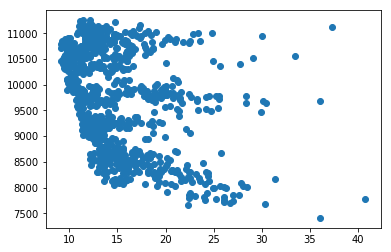

In [27]:
plt.scatter(X,y)

In [28]:
from sklearn.model_selection import train_test_split

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

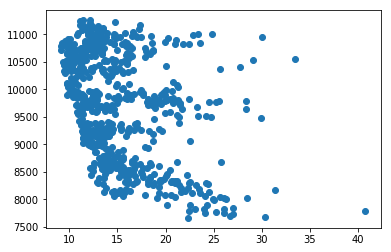

In [30]:
plt.scatter(X_train, y_train)

In [31]:
# Fitting Lineaer Regressioin to the dataset
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
X_train = X_train.reshape(-1,1)
lin_reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [32]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
poly = PolynomialFeatures(degree=6)
pipeline = Pipeline(
    [('poly', poly),('lin reg', lin_reg)]
)

In [33]:
pipeline.fit(X_train,y_train)

Pipeline(memory=None,
     steps=[('poly', PolynomialFeatures(degree=6, include_bias=True, interaction_only=False)), ('lin reg', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))])

### 利用vix polynomial (degree=6) 預估台股大盤指數

In [34]:
X_test = X_test.reshape(-1,1)
y_pred = pipeline.predict(X_test)

Text(0, 0.5, 'TW weighted Index')

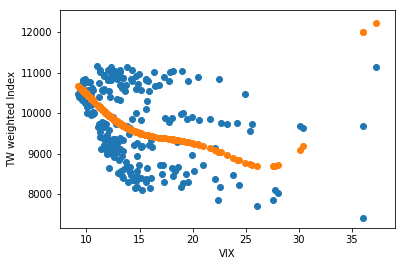

In [35]:
plt.scatter(X_test, y_test)
plt.scatter(X_test, y_pred)
plt.xlabel('VIX')
plt.ylabel('TW weighted Index')

In [36]:
print('Prediction score:', pipeline.score(X_train, y_train))

Prediction score: 0.2174381700471737


In [37]:
from sklearn.metrics import explained_variance_score

In [38]:
explained_variance_score(y_test, y_pred)

0.0738654822480439

In [39]:
from sklearn.metrics import r2_score

In [40]:
r2_score(y_test, y_pred)

0.07303562932093521